Including Scibert predictions instead of just keyword labeled data

In [1]:
# Imports

import pandas as pd
from pathlib import Path
import ast
import json
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

In [2]:
# Paths

processed_abstracts_path = Path("../../data/processed/abstracts")
save_path = processed_abstracts_path / "total_results"

ml_methods_path = processed_abstracts_path / "regex_scispacy/abstracts_with_ml_methods_regex.csv"
ml_category_path = processed_abstracts_path / "scibert_tuned/abstracts_with_predictions.csv"
production_category_path = processed_abstracts_path / "umap_kmean_tuned/abstracts_with_clusters.csv"
prod_cluster_keywords_path = processed_abstracts_path / "umap_kmean_tuned/cluster_keywords.json"

# Ensure directories exist
for p in [processed_abstracts_path, save_path]:
    p.mkdir(parents=True, exist_ok=True)

print("All directories verified/created.")

All directories verified/created.


In [3]:
# Load Data

# ML-methods
df_ml_methods = pd.read_csv(ml_methods_path)

# ML-category
df_ml_category = pd.read_csv(ml_category_path)

# Production category
df_prod_category = pd.read_csv(production_category_path)

# Production cluster keywords
with open(prod_cluster_keywords_path, "r", encoding="utf-8") as f:
    prod_cluster_keywords = json.load(f)

In [4]:
# Check columns
print(df_ml_methods.columns)
print(df_ml_category.columns)
print(df_prod_category.columns)

Index(['query_id', 'eid', 'doi', 'title', 'abstract', 'clean_abs',
       'ml_methods_regex', 'method_count'],
      dtype='object')
Index(['query_id', 'eid', 'doi', 'title', 'abstract', 'clean_abs',
       'is_supervised', 'is_unsupervised', 'is_reinforcement',
       'pred_is_supervised', 'pred_is_unsupervised', 'pred_is_reinforcement'],
      dtype='object')
Index(['query_id', 'eid', 'doi', 'title', 'abstract', 'clean_abs',
       'kmeans_cluster'],
      dtype='object')


In [5]:
# Check head of each dataset
df_ml_methods.head(2)

,query_id,eid,doi,title,abstract,clean_abs,ml_methods_regex,method_count
0,ml_end_of_life,2-s2.0-105008951371,10.3390/su17125511,Review and Novel Framework with Hui–Walter Met...,© 2025 by the authors.Consumers’ growing inter...,Consumers’ growing interest in sustainability ...,[],0
1,ml_end_of_life,2-s2.0-85174142475,10.3390/asi6050076,Measuring Carbon in Cities and Their Buildings...,© 2023 by the authors.According to the Europea...,"According to the European Green Deal, excessiv...",['Linear Regression'],1


In [6]:
df_ml_category.head(2)

,query_id,eid,doi,title,abstract,clean_abs,is_supervised,is_unsupervised,is_reinforcement,pred_is_supervised,pred_is_unsupervised,pred_is_reinforcement
0,ml_end_of_life,2-s2.0-105019728098,10.1016/B978-0-443-33740-6.00012-8,Blockchain-enabled decision system for reliabl...,© 2026 Elsevier Inc. All rights reserved.As th...,All rights reserved.As the production and cons...,False,False,False,0,0,1
1,ml_end_of_life,2-s2.0-105018918299,10.1080/19397038.2025.2563271,Systematic review of data modelling methods fo...,© 2025 The Author(s). Published by Informa UK ...,"Published by Informa UK Limited, trading as Ta...",False,False,False,0,0,0


In [7]:
df_prod_category.head(2)

,query_id,eid,doi,title,abstract,clean_abs,kmeans_cluster
0,ml_end_of_life,2-s2.0-105019728098,10.1016/B978-0-443-33740-6.00012-8,Blockchain-enabled decision system for reliabl...,© 2026 Elsevier Inc. All rights reserved.As th...,All rights reserved.As the production and cons...,7
1,ml_end_of_life,2-s2.0-105018918299,10.1080/19397038.2025.2563271,Systematic review of data modelling methods fo...,© 2025 The Author(s). Published by Informa UK ...,"Published by Informa UK Limited, trading as Ta...",0


In [8]:
df_ml_category.info()
print()
df_ml_methods.info()
print()
df_prod_category.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33130 entries, 0 to 33129
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   query_id               33130 non-null  object
 1   eid                    33130 non-null  object
 2   doi                    33129 non-null  object
 3   title                  33130 non-null  object
 4   abstract               33130 non-null  object
 5   clean_abs              33129 non-null  object
 6   is_supervised          33130 non-null  bool  
 7   is_unsupervised        33130 non-null  bool  
 8   is_reinforcement       33130 non-null  bool  
 9   pred_is_supervised     33130 non-null  int64 
 10  pred_is_unsupervised   33130 non-null  int64 
 11  pred_is_reinforcement  33130 non-null  int64 
dtypes: bool(3), int64(3), object(6)
memory usage: 2.4+ MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33130 entries, 0 to 33129
Data columns (total 8 columns):
 #   Colu

In [9]:
# Config

ID_COL = "doi"
RAW_ML_METHOD_COL = "ml_methods_regex"
ML_METHOD_COL = "ml_method"
ML_CAT_COL = "ml_category"
RAW_PROD_CAT_COL = "kmeans_cluster"
PROD_CAT_COL = "prod_category"



In [10]:
# Build ML categories per axis

ml_pred_cols = ["pred_is_supervised", "pred_is_unsupervised", "pred_is_reinforcement"]

ml_long = (
    df_ml_category[[ID_COL] + ml_pred_cols]
    .melt(id_vars=ID_COL, var_name="ml_axis", value_name="is_active")
)

ml_long = ml_long[ml_long["is_active"] == 1].copy()

ml_long[ML_CAT_COL] = ml_long["ml_axis"].map({
    "pred_is_supervised": "supervised",
    "pred_is_unsupervised": "unsupervised",
    "pred_is_reinforcement": "reinforcement",
})

ml_long = ml_long[[ID_COL, ML_CAT_COL]]

ml_long[ML_CAT_COL].value_counts()


ml_category
supervised       21240
reinforcement     4030
unsupervised      3958
Name: count, dtype: int64

In [11]:
# Parse ML method list column

def parse_method_list(x):
    if isinstance(x, list):
        return x
    if pd.isna(x):
        return []
    s = str(x).strip()
    if not s or s == "[]":
        return []
    try:
        v = ast.literal_eval(s)
        if isinstance(v, list):
            return v
        return [str(v)]
    except (ValueError, SyntaxError):
        return [s]

df_ml_methods["ml_methods_list"] = df_ml_methods[RAW_ML_METHOD_COL].apply(parse_method_list)
df_ml_methods[[RAW_ML_METHOD_COL, "ml_methods_list"]].head(5)


,ml_methods_regex,ml_methods_list
0,[],[]
1,['Linear Regression'],[Linear Regression]
2,"['Linear Regression', 'Support Vector Regressi...","[Linear Regression, Support Vector Regression,..."
3,['Neural Network'],[Neural Network]
4,[],[]


In [12]:
# Explode methods to one row per doi–method

df_methods_long = (
    df_ml_methods[[ID_COL, "ml_methods_list"]]
    .explode("ml_methods_list")
    .rename(columns={"ml_methods_list": ML_METHOD_COL})
)

df_methods_long = df_methods_long[
    df_methods_long[ML_METHOD_COL].notna()
    & (df_methods_long[ML_METHOD_COL].astype(str).str.strip() != "")
]

df_methods_long.head()


,doi,ml_method
1,10.3390/asi6050076,Linear Regression
2,10.1016/j.resconrec.2023.107073,Linear Regression
2,10.1016/j.resconrec.2023.107073,Support Vector Regression
2,10.1016/j.resconrec.2023.107073,Gradient Boosting
3,10.1016/j.dche.2023.100103,Neural Network


In [13]:
# Production categories

df_prod_long = (
    df_prod_category[[ID_COL, RAW_PROD_CAT_COL]]
    .rename(columns={RAW_PROD_CAT_COL: PROD_CAT_COL})
)

df_prod_long.head()


,doi,prod_category
0,10.1016/B978-0-443-33740-6.00012-8,7
1,10.1080/19397038.2025.2563271,0
2,10.1109/TEMSCON-ASPAC62480.2024.11025082,3
3,10.1188/23.CJON.595-601,0
4,10.1039/d3va00106g,0


In [14]:
# Full long table: one row per doi–method–ml_category–prod_category

df_all = (
    df_methods_long[[ID_COL, ML_METHOD_COL]]
    .merge(ml_long, on=ID_COL, how="inner")
    .merge(df_prod_long, on=ID_COL, how="inner")
)

print(df_all.shape)
df_all.head()


(35376, 4)


,doi,ml_method,ml_category,prod_category
0,10.3390/asi6050076,Linear Regression,supervised,3
1,10.1016/j.resconrec.2023.107073,Linear Regression,supervised,7
2,10.1016/j.resconrec.2023.107073,Support Vector Regression,supervised,7
3,10.1016/j.resconrec.2023.107073,Gradient Boosting,supervised,7
4,10.1016/j.dche.2023.100103,Neural Network,supervised,12


In [15]:
# Quick sanity check and neural network count

print("ML categories:")
print(df_all[ML_CAT_COL].value_counts())

print("\nProduction categories:")
print(df_all[PROD_CAT_COL].value_counts())

print("\nExample methods:")
print(df_all[ML_METHOD_COL].value_counts().head(20))


ML categories:
ml_category
supervised       27972
unsupervised      5246
reinforcement     2158
Name: count, dtype: int64

Production categories:
prod_category
8     5755
5     4341
9     3409
2     3250
12    2943
3     2541
7     2361
4     2311
0     2263
6     2171
1     1684
11    1461
10     886
Name: count, dtype: int64

Example methods:
ml_method
Neural Network                  6741
Random Forest                   3431
Support Vector Machine          2540
Decision Tree                   1722
Convolutional Neural Network    1420
Gradient Boosting               1276
XGBoost                         1205
LSTM                            1182
Linear Regression                989
Principal Component Analysis     949
K-Nearest Neighbors              939
Bayesian Method                  879
Genetic Algorithm                796
Support Vector Regression        782
Autoencoder                      631
Particle Swarm Optimization      612
Logistic Regression              544
K-Means       

In [16]:
# Counts per (ML category, production category, method)

group_cols = [ML_CAT_COL, PROD_CAT_COL, ML_METHOD_COL]

method_counts = (
    df_all
    .groupby(group_cols)[ID_COL]
    .nunique()
    .reset_index(name="n_articles")
)

method_counts.head()


,ml_category,prod_category,ml_method,n_articles
0,reinforcement,0,A3C,6
1,reinforcement,0,Actor-Critic,28
2,reinforcement,0,Ant Colony Optimization,7
3,reinforcement,0,Attention Mechanism,3
4,reinforcement,0,Autoencoder,2


In [17]:
# Total unique articles per (ML category, production category)

cell_totals = (
    df_all
    .groupby([ML_CAT_COL, PROD_CAT_COL])[ID_COL]
    .nunique()
    .reset_index(name="cell_total")
)

cell_totals.head()


,ml_category,prod_category,cell_total
0,reinforcement,0,355
1,reinforcement,1,147
2,reinforcement,2,84
3,reinforcement,3,150
4,reinforcement,4,68


In [18]:
# Order categories by frequency of unique articles

ml_cat_order = (
    df_all
    .groupby(ML_CAT_COL)[ID_COL]
    .nunique()
    .sort_values(ascending=False)
    .index
    .tolist()
)

prod_cat_order = (
    df_all
    .groupby(PROD_CAT_COL)[ID_COL]
    .nunique()
    .sort_values(ascending=False)
    .index
    .tolist()
)

ml_cat_order, prod_cat_order


(['supervised', 'unsupervised', 'reinforcement'],
 [8, 5, 9, 12, 2, 0, 3, 7, 4, 6, 1, 11, 10])

In [19]:
# Top-k methods per cell

TOP_K = 3

method_counts["rank_in_cell"] = (
    method_counts
    .groupby([ML_CAT_COL, PROD_CAT_COL])["n_articles"]
    .rank(method="dense", ascending=False)
)

top_methods = (
    method_counts[method_counts["rank_in_cell"] <= TOP_K]
    .merge(cell_totals, on=[ML_CAT_COL, PROD_CAT_COL], how="left")
    .sort_values([ML_CAT_COL, PROD_CAT_COL, "n_articles"], ascending=[True, True, False])
)

top_methods.head(10)


,ml_category,prod_category,ml_method,n_articles,rank_in_cell,cell_total
1,reinforcement,0,Neural Network,105,1.0,355
0,reinforcement,0,Deep Reinforcement Learning,92,2.0,355
2,reinforcement,0,Q-Learning,74,3.0,355
5,reinforcement,1,Neural Network,54,1.0,147
3,reinforcement,1,Decision Tree,31,2.0,147
4,reinforcement,1,Deep Reinforcement Learning,22,3.0,147
7,reinforcement,2,Neural Network,29,1.0,84
8,reinforcement,2,Random Forest,23,2.0,84
6,reinforcement,2,LSTM,9,3.0,84
9,reinforcement,2,Support Vector Machine,9,3.0,84


In [20]:
# Build 2D map summary

def summarize_cell(group):
    total = int(group["cell_total"].iloc[0])
    methods_str = ", ".join(
        f"{m} ({int(n)})"
        for m, n in zip(group[ML_METHOD_COL], group["n_articles"])
    )
    return pd.Series({"summary": f"n={total}; top: {methods_str}"})

cell_summary = (
    top_methods
    .groupby([ML_CAT_COL, PROD_CAT_COL])
    .apply(summarize_cell)
    .reset_index()
)

cell_summary.head()


/tmp/ipykernel_3331257/602492248.py:14: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(summarize_cell)


,ml_category,prod_category,summary
0,reinforcement,0,"n=355; top: Neural Network (105), Deep Reinfor..."
1,reinforcement,1,"n=147; top: Neural Network (54), Decision Tree..."
2,reinforcement,2,"n=84; top: Neural Network (29), Random Forest ..."
3,reinforcement,3,"n=150; top: Neural Network (57), Deep Reinforc..."
4,reinforcement,4,"n=68; top: Deep Reinforcement Learning (23), N..."


In [21]:
# Pivot to 2D grid

summary_grid = cell_summary.pivot(
    index=ML_CAT_COL,
    columns=PROD_CAT_COL,
    values="summary"
)

summary_grid = summary_grid.reindex(index=ml_cat_order, columns=prod_cat_order)

summary_grid


prod_category,8,5,9,12,2,0,3,7,4,6,1,11,10
ml_category,,,,,,,,,,,,,
supervised,"n=1929; top: Neural Network (771), Random Fore...","n=1771; top: Neural Network (935), Random Fore...","n=1419; top: Neural Network (716), Convolution...","n=1166; top: Neural Network (532), Random Fore...","n=1065; top: Random Forest (405), Neural Netwo...","n=708; top: Neural Network (326), Support Vect...","n=871; top: Neural Network (416), Random Fores...","n=831; top: Neural Network (249), Random Fores...","n=640; top: Neural Network (242), Support Vect...","n=744; top: Neural Network (320), Random Fores...","n=621; top: Neural Network (264), Support Vect...","n=577; top: Neural Network (256), Random Fores...","n=345; top: Neural Network (140), LSTM (68), R..."
unsupervised,"n=485; top: Neural Network (142), Principal Co...","n=237; top: Neural Network (88), Principal Com...","n=239; top: Neural Network (77), Principal Com...","n=121; top: Principal Component Analysis (45),...","n=171; top: Principal Component Analysis (60),...","n=114; top: Principal Component Analysis (30),...","n=89; top: Neural Network (36), K-Means (20), ...","n=176; top: K-Means (43), Neural Network (39),...","n=392; top: Neural Network (119), Autoencoder ...","n=151; top: Principal Component Analysis (44),...","n=154; top: Neural Network (44), Principal Com...","n=51; top: Neural Network (13), Random Forest ...","n=46; top: Neural Network (14), Autoencoder (1..."
reinforcement,"n=87; top: Neural Network (29), Bayesian Metho...","n=63; top: Neural Network (27), Bayesian Metho...","n=39; top: Neural Network (19), Convolutional ...","n=74; top: Neural Network (26), Bayesian Metho...","n=84; top: Neural Network (29), Random Forest ...","n=355; top: Neural Network (105), Deep Reinfor...","n=150; top: Neural Network (57), Deep Reinforc...","n=124; top: Neural Network (38), Explainable A...","n=68; top: Deep Reinforcement Learning (23), N...","n=55; top: Neural Network (26), Deep Reinforce...","n=147; top: Neural Network (54), Decision Tree...","n=33; top: Bayesian Method (13), Neural Networ...","n=14; top: Neural Network (4), Deep Q-Network ..."


In [22]:
# Short labels for production clusters based on first 3 keywords

def make_cluster_label(cid):
    cid_str = str(cid)
    if cid_str in prod_cluster_keywords:
        words = prod_cluster_keywords[cid_str][:4]
        return f"{cid} - " + ", ".join(words)
    return str(cid)

prod_cluster_label_map = {
    c: make_cluster_label(c)
    for c in df_all[PROD_CAT_COL].unique()
}

prod_cluster_label_map


{3: '3 - energy, power, solar, wind',
 7: '7 - product, supply, design, business',
 12: '12 - process, production, optimization, drug',
 0: '0 - control, process, scheduling, optimization',
 10: '10 - battery, batteries, rul, ion',
 8: '8 - maintenance, predictive maintenance, predictive, fault',
 11: '11 - materials, concrete, properties, strength',
 9: '9 - process, manufacturing, defect, quality',
 5: '5 - process, manufacturing, additive, additive manufacturing',
 1: '1 - manufacturing, industry, industrial, digital',
 2: '2 - food, crop, agricultural, agriculture',
 4: '4 - detection, anomaly, security, attacks',
 6: '6 - oil, reservoir, production, wells'}

In [23]:
# Summarize top-3 methods per ML × Production category into one row
def summarize_top3_row(group, top_k=3):
    # Total number of articles in this cell
    total = int(group["cell_total"].iloc[0])
    
    # Select the top-k methods and counts
    top = list(zip(group[ML_METHOD_COL], group["n_articles"]))[:top_k]
    
    # Base row information
    row = {
        "ml_category": group[ML_CAT_COL].iloc[0],
        "prod_category": group[PROD_CAT_COL].iloc[0],
        "prod_label": prod_cluster_label_map.get(group[PROD_CAT_COL].iloc[0], "N/A"),
        "n_in_cell": total
    }
    
    # Add method columns (blank if fewer than 3 found)
    for i in range(top_k):
        if i < len(top):
            method, count = top[i]
            row[f"method_{i+1}"] = f"{method} ({int(count)})"
        else:
            row[f"method_{i+1}"] = ""
    
    return pd.Series(row)

# Apply to all groups and export as clean summarizing table
cell_table_rows = (
    top_methods
    .groupby([ML_CAT_COL, PROD_CAT_COL])
    .apply(summarize_top3_row)
    .reset_index(drop=True)
)

# Save to file (optional)
cell_table_rows.to_csv("top3_methods_per_cell.csv", index=False)

cell_table_rows.head()


/tmp/ipykernel_3331257/616100336.py:31: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(summarize_top3_row)


,ml_category,prod_category,prod_label,n_in_cell,method_1,method_2,method_3
0,reinforcement,0,"0 - control, process, scheduling, optimization",355,Neural Network (105),Deep Reinforcement Learning (92),Q-Learning (74)
1,reinforcement,1,"1 - manufacturing, industry, industrial, digital",147,Neural Network (54),Decision Tree (31),Deep Reinforcement Learning (22)
2,reinforcement,2,"2 - food, crop, agricultural, agriculture",84,Neural Network (29),Random Forest (23),LSTM (9)
3,reinforcement,3,"3 - energy, power, solar, wind",150,Neural Network (57),Deep Reinforcement Learning (23),Genetic Algorithm (18)
4,reinforcement,4,"4 - detection, anomaly, security, attacks",68,Deep Reinforcement Learning (23),Neural Network (20),Deep Neural Network (7)


In [24]:
bubble_df = cell_summary.merge(cell_totals, on=[ML_CAT_COL, PROD_CAT_COL])

bubble_df["prod_cluster_label"] = bubble_df[PROD_CAT_COL].map(prod_cluster_label_map)

fig = px.scatter(
    bubble_df,
    x="prod_cluster_label",
    y=ML_CAT_COL,
    size="cell_total",
    # text="summary",
    size_max=60
)

fig.update_traces(textposition="top center")
fig.update_layout(
    width=1800,  
    height=600   
)
fig.show()


In [25]:
# Count articles per production × ML category
count_table = df_all.groupby(["prod_category", "ml_category"]).size().unstack()

# Convert to shares per production category
share_table = count_table.div(count_table.sum(axis=1), axis=0)

# Round for readability
share_table = share_table.round(2)

print(share_table)


ml_category    reinforcement  supervised  unsupervised
prod_category                                         
0                       0.27        0.63          0.10
1                       0.12        0.70          0.18
2                       0.05        0.81          0.14
3                       0.10        0.82          0.08
4                       0.05        0.60          0.35
5                       0.02        0.86          0.12
6                       0.05        0.79          0.16
7                       0.08        0.77          0.15
8                       0.02        0.78          0.19
9                       0.02        0.84          0.14
10                      0.02        0.87          0.11
11                      0.04        0.88          0.08
12                      0.04        0.87          0.09


In [26]:
# Label map from cluster id to short description
def make_cluster_label(cid):
    cid_str = str(cid)
    words = prod_cluster_keywords.get(cid_str, [])[:4]
    if words:
        return f"{cid} | " + ", ".join(words)
    return str(cid)

prod_label_map = {cid: make_cluster_label(cid) for cid in prod_cat_order}
prod_label_to_id = {v: k for k, v in prod_label_map.items()}

# Numeric grid for heatmap
numeric_grid = (
    cell_totals
    .pivot(index=ML_CAT_COL, columns=PROD_CAT_COL, values="cell_total")
    .reindex(index=ml_cat_order, columns=prod_cat_order)
)


In [27]:
# Widgets

ml_cat_dropdown = widgets.Dropdown(
    options=ml_cat_order,
    description="ML cat",
    layout=widgets.Layout(width="300px")
)

prod_dropdown = widgets.Dropdown(
    options=[prod_label_map[c] for c in prod_cat_order],
    description="Prod",
    layout=widgets.Layout(width="400px")
)


In [28]:
# Callback for dashboard

def update_dashboard(ml_cat, prod_label, top_k=15):
    prod_id = prod_label_to_id[prod_label]
    
    subset = (
        method_counts
        .query(f"{ML_CAT_COL} == @ml_cat and {PROD_CAT_COL} == @prod_id")
        .sort_values("n_articles", ascending=False)
    )
    
    if subset.empty:
        print(f"No articles for cell: {ml_cat} × {prod_label}")
        return
    
    cell_n = int(
        cell_totals.query(
            f"{ML_CAT_COL} == @ml_cat and {PROD_CAT_COL} == @prod_id"
        )["cell_total"].iloc[0]
    )
    
    print(f"Cell: {ml_cat} × {prod_label}")
    print(f"Unique articles in cell: {cell_n}")
    print("\nTop methods:")
    
    display(subset[[ML_METHOD_COL, "n_articles"]].head(top_k))
    
    top_plot = subset.head(top_k)
    
    plt.figure(figsize=(8, 4))
    plt.barh(top_plot[ML_METHOD_COL].astype(str), top_plot["n_articles"])
    plt.gca().invert_yaxis()
    plt.xlabel("Number of articles")
    plt.title("Top methods in selected cell")
    plt.tight_layout()
    plt.show()


In [29]:
# Bind widgets to callback

ui = widgets.VBox([ml_cat_dropdown, prod_dropdown])

out = widgets.interactive_output(
    update_dashboard,
    {"ml_cat": ml_cat_dropdown, "prod_label": prod_dropdown}
)

display(ui, out)


Output()

In [30]:
# ML category flags per article
ml_flag_cols = ["pred_is_supervised", "pred_is_unsupervised", "pred_is_reinforcement"]

df_ml_flags = df_ml_category[[ID_COL] + ml_flag_cols].copy()

# Count active categories
df_ml_flags["n_active"] = df_ml_flags[ml_flag_cols].sum(axis=1)

# Remove "none" (articles with zero ML categories)
df_ml_flags = df_ml_flags[df_ml_flags["n_active"] > 0].copy()

# Multi-label flags
df_ml_flags["is_multi"] = df_ml_flags["n_active"] > 1
df_ml_flags["multi_type"] = df_ml_flags["n_active"].map({
    1: "single",
    2: "double",
    3: "triple"
})

df_ml_flags["multi_type"].value_counts()


multi_type
single    24733
double     2111
triple       91
Name: count, dtype: int64

In [31]:
# Join ML flags with production cluster
ml_prod_flags = df_ml_flags.merge(
    df_prod_long[[ID_COL, PROD_CAT_COL]],
    on=ID_COL,
    how="left"
)

# Compute share per cluster
share_multi_by_prod = (
    ml_prod_flags
    .groupby(PROD_CAT_COL)["is_multi"]
    .mean()
    .reset_index(name="share_multi")
)

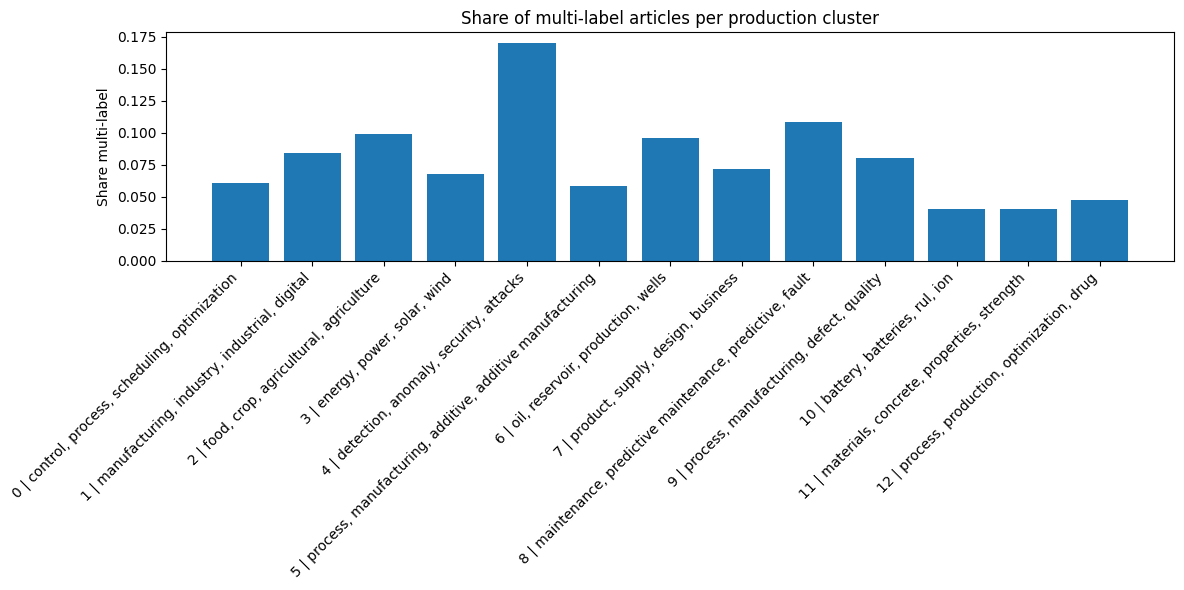

In [32]:
plot_df = share_multi_by_prod.copy()
plot_df["prod_label"] = plot_df[PROD_CAT_COL].map(prod_label_map)

plt.figure(figsize=(12, 6))
plt.bar(plot_df["prod_label"], plot_df["share_multi"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Share multi-label")
plt.title("Share of multi-label articles per production cluster")
plt.tight_layout()
plt.show()


In [33]:
ml_axis_long = df_ml_flags.melt(
    id_vars=[ID_COL, "is_multi"],
    value_vars=ml_flag_cols,
    var_name="ml_axis",
    value_name="is_active"
)

ml_axis_long = ml_axis_long[ml_axis_long["is_active"] == 1].copy()

ml_axis_long["ml_axis"] = ml_axis_long["ml_axis"].map({
    "pred_is_supervised": "supervised",
    "pred_is_unsupervised": "unsupervised",
    "pred_is_reinforcement": "reinforcement"
})

share_multi_by_axis = (
    ml_axis_long
    .groupby("ml_axis")["is_multi"]
    .mean()
    .reset_index(name="share_multi")
)

share_multi_by_axis


,ml_axis,share_multi
0,reinforcement,0.121588
1,supervised,0.099670
2,unsupervised,0.477009


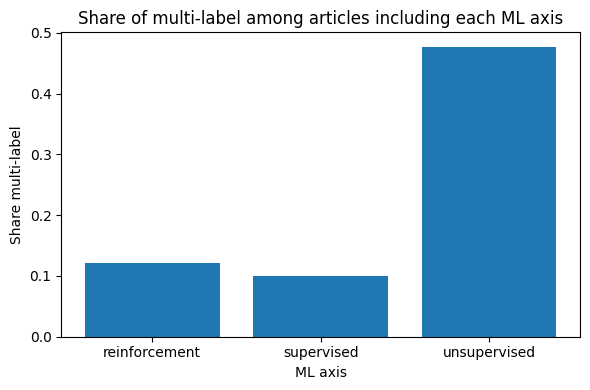

In [34]:
# Bar plot: share of multi-label among articles that include each axis

plt.figure(figsize=(6, 4))
plt.bar(share_multi_by_axis["ml_axis"], share_multi_by_axis["share_multi"])
plt.ylabel("Share multi-label")
plt.xlabel("ML axis")
plt.title("Share of multi-label among articles including each ML axis")
plt.tight_layout()
plt.show()


In [35]:
# Keep only multi-label (>=2)
df_ml_flags = df_ml_flags[df_ml_flags["n_active"] >= 2].copy()

def make_combo(row):
    parts = []
    if row["pred_is_supervised"] == 1:
        parts.append("supervised")
    if row["pred_is_unsupervised"] == 1:
        parts.append("unsupervised")
    if row["pred_is_reinforcement"] == 1:
        parts.append("reinforcement")
    return "+".join(parts)

df_ml_flags["ml_combo"] = df_ml_flags.apply(make_combo, axis=1)


df_combo_prod = df_ml_flags.merge(
    df_prod_long[[ID_COL, PROD_CAT_COL]],
    on=ID_COL,
    how="left"
)

combo_by_prod = (
    df_combo_prod
    .groupby([PROD_CAT_COL, "ml_combo"])[ID_COL]
    .nunique()
    .reset_index(name="n_articles")
    .sort_values(["prod_category", "n_articles"], ascending=[True, False])
)

top3_combo_prod = (
    combo_by_prod
    .sort_values("n_articles", ascending=False)
    .head(3)
)

top3_combo_prod



,prod_category,ml_combo,n_articles
33,8.0,supervised+unsupervised,354
17,4.0,supervised+unsupervised,265
37,9.0,supervised+unsupervised,203


In [36]:
df_ml_flags_all = df_ml_category[[ID_COL] + ml_flag_cols].copy()
df_ml_flags_all["n_active"] = df_ml_flags_all[ml_flag_cols].sum(axis=1)

# Separate none vs labeled
none_df = df_ml_flags_all[df_ml_flags_all["n_active"] == 0].copy()
labeled_df = df_ml_flags_all[df_ml_flags_all["n_active"] > 0].copy()

print("Total none:", len(none_df))
print("Total labeled:", len(labeled_df))


Total none: 6195
Total labeled: 26935


In [37]:
# Count how many total articles per production cluster
total_per_cluster = (
    df_prod_long[PROD_CAT_COL]
    .value_counts()
    .sort_index()
    .rename("total_cluster")
)

# Count none-articles per cluster
none_prod = none_df.merge(
    df_prod_long[[ID_COL, PROD_CAT_COL]],
    on=ID_COL,
    how="left"
)

none_per_cluster = (
    none_prod[PROD_CAT_COL]
    .value_counts()
    .sort_index()
    .rename("none_count")
)

# Combine counts
none_stats = (
    pd.concat([none_per_cluster, total_per_cluster], axis=1)
    .fillna(0)
)

# Compute share
none_stats["none_share"] = none_stats["none_count"] / none_stats["total_cluster"]

# Add readable labels (3 keywords per cluster)
def make_cluster_label(cid):
    words = prod_cluster_keywords.get(str(cid), [])[:3]
    if words:
        return f"{cid} | " + ", ".join(words)
    return str(cid)

none_stats["cluster_label"] = [
    make_cluster_label(cid) for cid in none_stats.index
]

# Reorder columns
none_stats = none_stats[
    ["cluster_label", "none_count", "total_cluster", "none_share"]
]

none_stats


,cluster_label,none_count,total_cluster,none_share
prod_category,,,,
0.0,0.0,375,2341,0.160188
1.0,1.0,1277,3423,0.373065
2.0,2.0,280,2230,0.125561
3.0,3.0,209,1839,0.113649
4.0,4.0,500,2277,0.219587
5.0,5.0,635,3783,0.167856
6.0,6.0,173,1516,0.114116
7.0,7.0,779,3349,0.232607
8.0,8.0,360,4103,0.087741


In [38]:
# Prepare method lists
df_methods = df_ml_methods[[ID_COL, "ml_methods_list"]].copy()
df_methods["n_methods"] = df_methods["ml_methods_list"].apply(
    lambda x: len(x) if isinstance(x, list) else 0
)

# Merge into none vs labeled
none_methods = none_df.merge(df_methods, on=ID_COL, how="left")
labeled_methods = labeled_df.merge(df_methods, on=ID_COL, how="left")

print("Avg methods (none):", none_methods["n_methods"].mean())
print("Avg methods (labeled):", labeled_methods["n_methods"].mean())

print("\nMedian methods (none):", none_methods["n_methods"].median())
print("Median methods (labeled):", labeled_methods["n_methods"].median())

# Share with zero methods
none_zero_share = (none_methods["n_methods"] == 0).mean()
labeled_zero_share = (labeled_methods["n_methods"] == 0).mean()

print("\nShare with zero methods (none):", none_zero_share)
print("Share with zero methods (labeled):", labeled_zero_share)


Avg methods (none): 0.2019370460048426
Avg methods (labeled): 1.16658622609987

Median methods (none): 0.0
Median methods (labeled): 1.0

Share with zero methods (none): 0.8395480225988701
Share with zero methods (labeled): 0.449118247633191
